<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd

In [2]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [39]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [40]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self, rebuild=True):
    if rebuild:
      for key in self.labels:
        print(key)
        for img_file in tqdm(os.listdir(key)):
          try:
            path = os.path.join(key, img_file)
            image = cv2.imread(path)
            image = cv2.resize(image, (self.img_size, self.img_size))
            image = np.array(image)
            self.training_data.append([image, int(self.labels[key])])
            if key == self.sedans:
              self.sedan_count+=1
            elif key == self.coupes:
              self.coupe_count+=1
            elif key == self.suvs:
              self.suv_count+=1
            elif key == self.trucks:
              self.truck_count+=1
          except Exception as e:
            pass
      np.random.shuffle(self.training_data)
      np.save('gdrive/My Drive/Neural Networks/loaded_npy_files/CarType75x75.npy', self.training_data)
      print(f'\nsedan images: {self.sedan_count}')
      print(f'coupe images: {self.coupe_count}')
      print(f'suv images: {self.suv_count}')
      print(f'truck images: {self.truck_count}')
      print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
      print('All done!')
    else:
      print('Rebuild flag set to false, data to be loaded from path.\nSet rebuild to true to reload dataset.')
      pass

In [59]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset(rebuild=False)

#  loading dataset into object
dataset = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/CarType100x100.npy', allow_pickle=True)
print('\nDone!')

Rebuild flag set to false, data to be loaded from path.
Set rebuild to true to reload dataset.

Done!


In [60]:
#  checking dataset
len(dataset)

81332

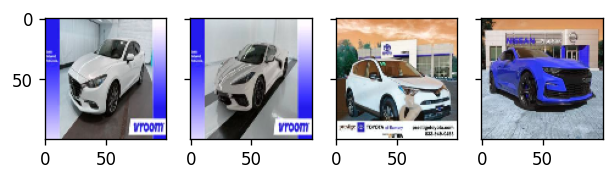

In [61]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[1][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[19929][0])

In [62]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
#test_indices, dataset_indices = train_val_split(dataset, 0.1)
#val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  saving indices for reproducbility
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', train_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', val_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', test_indices)

#  loading saved indices
train_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', allow_pickle=True))
val_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', allow_pickle=True))
test_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', allow_pickle=True))

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

In [63]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    #  extracting label from index
    label = torch.tensor(int(self.loaded_dataset[idx][1]))
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
    return (image, label)

In [71]:
#  creating an instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 200
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [65]:
#  building neural network
class CarRecognition(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [66]:
def accuracy(network, train_loader, verbose=False):
  #  creating counter for correctly classified instances
  correctly_classified = 0
  #  creating counter for all instances
  all_instances = 0
  #  looping through every batch
  for images, labels in tqdm_notebook(train_loader):
    images, labels = images.to(device), labels.to(device)
    #  classifying
    outputs = network(images)
    #  deriving the index of model prediction
    predicted_labels = torch.argmax(outputs, dim=1)
    #  comparing and counting the number of correct predictions
    correct_labels = sum(predicted_labels==labels)
    #  counting correct predictions
    correctly_classified+=correct_labels.item()
    #  counting all instances
    all_instances+=len(labels)
  if verbose:
    return print(f'model predicts all instances to {round((correctly_classified/all_instances)*100, 2)}% accuracy')
  else:
    return correctly_classified/all_instances

In [67]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader):
  #  creating a list to hold metrics
  metric_log = []
  for epoch in range(epochs):
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    total_instances = 0
    for images, labels in tqdm_notebook(train_loader):
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      with torch.no_grad():
        #  summing loss
        total_loss+=loss.sum().item()
        #  summing instances
        total_instances+=len(labels)
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()
    #  deriving training accuracy
    with torch.no_grad():
      print('Deriving training accuracy...')
      train_accuracy = accuracy(network, train_loader)
    #  deriving validation loss and accuracy
    with torch.no_grad():
      print('Deriving validation loss...')
      total_val_loss = 0
      total_val_instances = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  summing val_loss
        total_val_loss+=val_loss.sum().item()
        #  summing total_val_instances
        total_val_instances+=len(val_labels)
      print('Deriving validation accuracy...')
      #  computing accuracy
      val_accuracy = accuracy(network, val_loader)
    #  appending metrics to list
    metric_log.append([epoch+1, total_loss/total_instances, train_accuracy, total_val_loss/total_val_instances, val_accuracy])
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs} Training_loss: {round(total_loss/total_instances, 5)} Training_accuracy: {round(train_accuracy, 5)} Validation_loss: {round(total_val_loss/total_val_instances, 5)} Validation_accuracy: {round(val_accuracy, 5)}')
  np.save(f'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_30epochs.npy', metric_log)

In [72]:
model = CarRecognition()
model.to(device)

loss_fn = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

train_model(network=model, epochs=epochs, loss_function=loss_fn, opt=optimizer, train_loader=train_dl, val_loader=val_dl)


Training Epoch 1/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 1/30 Training_loss: 0.0064 Training_accuracy: 0.60046 Validation_loss: 0.00466 Validation_accuracy: 0.59519

Training Epoch 2/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 2/30 Training_loss: 0.00336 Training_accuracy: 0.79788 Validation_loss: 0.00279 Validation_accuracy: 0.77485

Training Epoch 3/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 3/30 Training_loss: 0.00209 Training_accuracy: 0.87707 Validation_loss: 0.00208 Validation_accuracy: 0.83578

Training Epoch 4/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 4/30 Training_loss: 0.00145 Training_accuracy: 0.92782 Validation_loss: 0.00167 Validation_accuracy: 0.86973

Training Epoch 5/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 5/30 Training_loss: 0.00104 Training_accuracy: 0.95335 Validation_loss: 0.00167 Validation_accuracy: 0.88011

Training Epoch 6/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 6/30 Training_loss: 0.00072 Training_accuracy: 0.96431 Validation_loss: 0.00171 Validation_accuracy: 0.88367

Training Epoch 7/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 7/30 Training_loss: 0.00052 Training_accuracy: 0.97363 Validation_loss: 0.00186 Validation_accuracy: 0.88374

Training Epoch 8/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 8/30 Training_loss: 0.00038 Training_accuracy: 0.9863 Validation_loss: 0.0019 Validation_accuracy: 0.89624

Training Epoch 9/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 9/30 Training_loss: 0.00028 Training_accuracy: 0.98356 Validation_loss: 0.00229 Validation_accuracy: 0.89193

Training Epoch 10/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 10/30 Training_loss: 0.00023 Training_accuracy: 0.98641 Validation_loss: 0.00211 Validation_accuracy: 0.89193

Training Epoch 11/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 11/30 Training_loss: 0.00021 Training_accuracy: 0.98904 Validation_loss: 0.00247 Validation_accuracy: 0.89145

Training Epoch 12/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 12/30 Training_loss: 0.00017 Training_accuracy: 0.98316 Validation_loss: 0.00255 Validation_accuracy: 0.89036

Training Epoch 13/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 13/30 Training_loss: 0.00016 Training_accuracy: 0.9918 Validation_loss: 0.00261 Validation_accuracy: 0.89699

Training Epoch 14/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 14/30 Training_loss: 0.00016 Training_accuracy: 0.99209 Validation_loss: 0.00245 Validation_accuracy: 0.9017

Training Epoch 15/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 15/30 Training_loss: 0.00014 Training_accuracy: 0.99102 Validation_loss: 0.00282 Validation_accuracy: 0.89426

Training Epoch 16/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 16/30 Training_loss: 0.00014 Training_accuracy: 0.98796 Validation_loss: 0.0029 Validation_accuracy: 0.8948

Training Epoch 17/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 17/30 Training_loss: 0.00013 Training_accuracy: 0.9946 Validation_loss: 0.00284 Validation_accuracy: 0.90033

Training Epoch 18/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 18/30 Training_loss: 0.00013 Training_accuracy: 0.99252 Validation_loss: 0.00269 Validation_accuracy: 0.89904

Training Epoch 19/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 19/30 Training_loss: 9e-05 Training_accuracy: 0.99279 Validation_loss: 0.00281 Validation_accuracy: 0.89794

Training Epoch 20/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 20/30 Training_loss: 0.0001 Training_accuracy: 0.99252 Validation_loss: 0.00294 Validation_accuracy: 0.89788

Training Epoch 21/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 21/30 Training_loss: 0.00011 Training_accuracy: 0.99356 Validation_loss: 0.00271 Validation_accuracy: 0.9002

Training Epoch 22/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 22/30 Training_loss: 0.00011 Training_accuracy: 0.99361 Validation_loss: 0.00277 Validation_accuracy: 0.90286

Training Epoch 23/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 23/30 Training_loss: 0.00012 Training_accuracy: 0.99612 Validation_loss: 0.00291 Validation_accuracy: 0.90341

Training Epoch 24/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 24/30 Training_loss: 8e-05 Training_accuracy: 0.9946 Validation_loss: 0.003 Validation_accuracy: 0.90109

Training Epoch 25/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 25/30 Training_loss: 0.0001 Training_accuracy: 0.99406 Validation_loss: 0.00296 Validation_accuracy: 0.90218

Training Epoch 26/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 26/30 Training_loss: 0.0001 Training_accuracy: 0.9967 Validation_loss: 0.00278 Validation_accuracy: 0.9032

Training Epoch 27/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 27/30 Training_loss: 8e-05 Training_accuracy: 0.99587 Validation_loss: 0.0028 Validation_accuracy: 0.90129

Training Epoch 28/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 28/30 Training_loss: 9e-05 Training_accuracy: 0.9972 Validation_loss: 0.00297 Validation_accuracy: 0.90539

Training Epoch 29/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 29/30 Training_loss: 8e-05 Training_accuracy: 0.99638 Validation_loss: 0.00298 Validation_accuracy: 0.90232

Training Epoch 30/30


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving training accuracy...


  0%|          | 0/293 [00:00<?, ?it/s]

Deriving validation loss...


  0%|          | 0/74 [00:00<?, ?it/s]

Deriving validation accuracy...


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch: 30/30 Training_loss: 8e-05 Training_accuracy: 0.99715 Validation_loss: 0.00321 Validation_accuracy: 0.90327


In [ ]:
#  saving model state
#torch.save(model.state_dict(), f'gdrive/My Drive/Neural Networks/Model_States/CarType75x75_model_state_completed.pt')

In [74]:
#  loading metric log
metrics_log = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_30epochs.npy', allow_pickle=True)

In [3]:
metrics_100x100 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_30epochs.npy', allow_pickle=True)
metrics_75x75 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_30epochs.npy', allow_pickle=True)

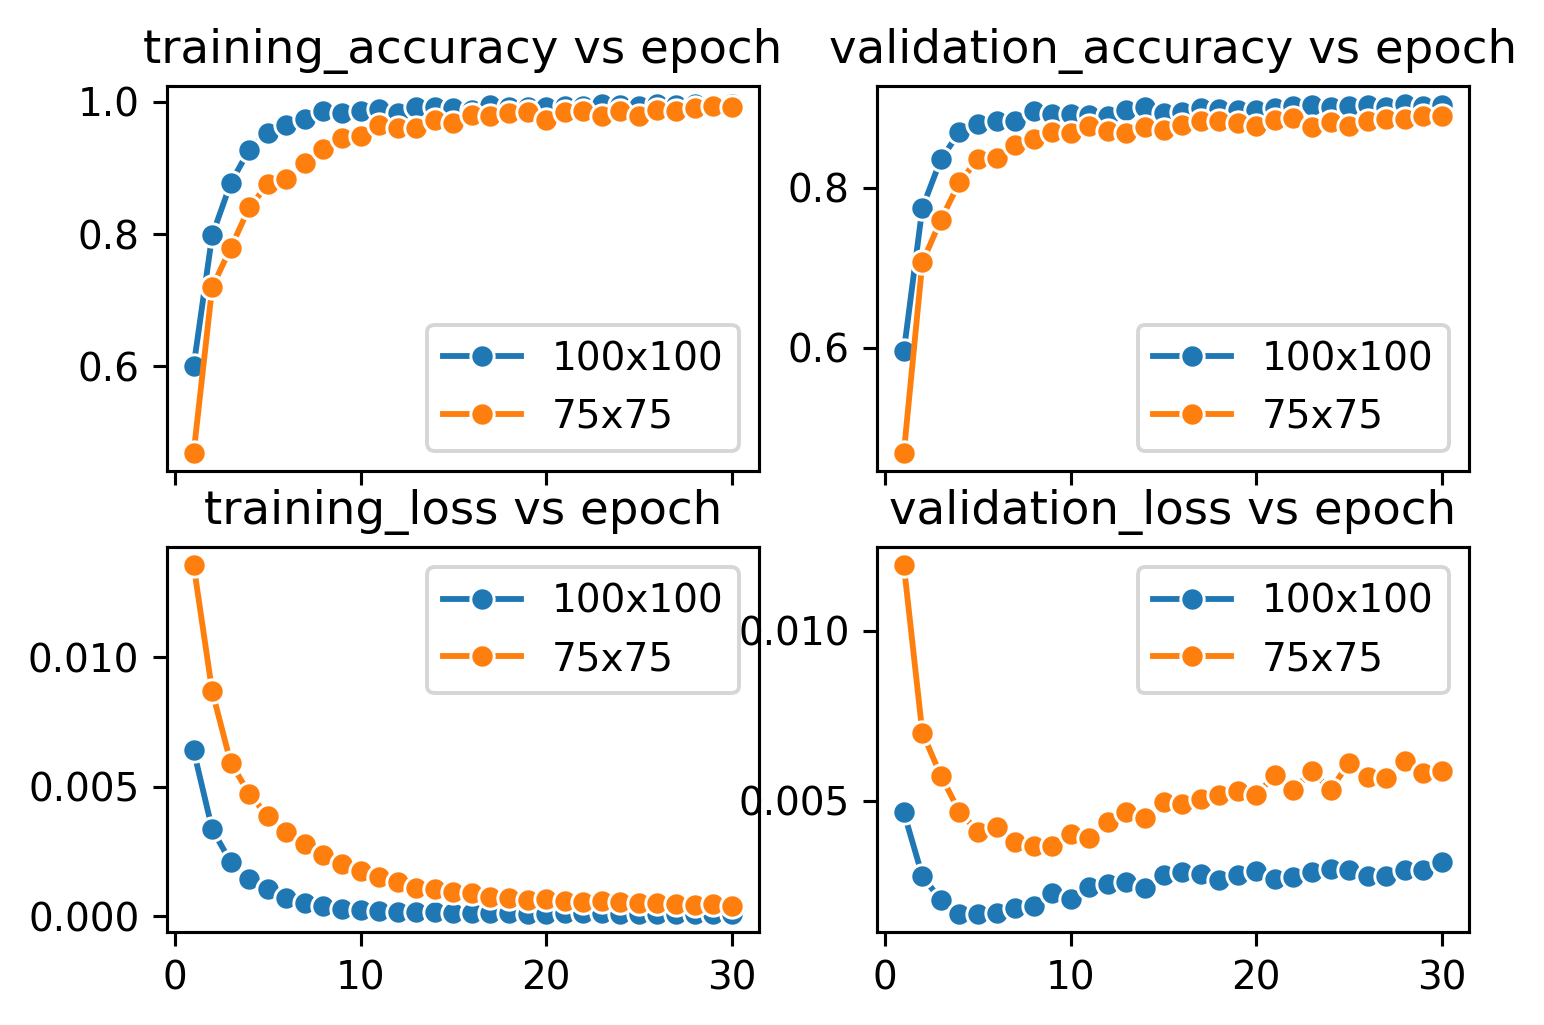

In [10]:
#  visualising metrics
figure, axes = plt.subplots(2,2, dpi=280, sharex=True)
axes[0,0].set_title('training_accuracy vs epoch')
axes[0,1].set_title('validation_accuracy vs epoch')
axes[1,0].set_title('training_loss vs epoch')
axes[1,1].set_title('validation_loss vs epoch')
#axes[0].ylabel('accuracy')
#axes[1].set_title('loss vs epoch')
#axes[1].ylabel('loss')
#axes[1].xlabel('epoch')

sns.lineplot(x=metrics_100x100[:,0], y=metrics_100x100[:,2], marker='o', label='100x100', ax=axes[0,0])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,2], marker='o', label='75x75', ax=axes[0,0])

sns.lineplot(x=metrics_100x100[:,0], y=metrics_100x100[:,4], marker='o', label='100x100', ax=axes[0,1])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,4], marker='o', label='75x75', ax=axes[0,1])

sns.lineplot(x=metrics_100x100[:,0], y=metrics_100x100[:,1], marker='o', label='100x100', ax=axes[1,0])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,1], marker='o', label='75x75', ax=axes[1,0])

sns.lineplot(x=metrics_100x100[:,0], y=metrics_100x100[:,3], marker='o', label='100x100', ax=axes[1,1])
sns.lineplot(x=metrics_75x75[:,0], y=metrics_75x75[:,3], marker='o', label='75x75', ax=axes[1,1])

In [ ]:
#  deriving test accuracy
accuracy(model, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

model predicts all instances to 93.78% accuracy


In [ ]:
def extract_results(network, dataloader, file_name):
  #  creating an empty list
  results = []
  labels = []
  #  classification
  with torch.no_grad():
    for img, lb in tqdm(dataloader):
      img, lb = img.to(device), lb.to(device)
      preds = network(img)
      results.extend(torch.argmax(preds, dim=1).tolist())
      labels.extend(lb.tolist())
  df = pd.DataFrame({'predicted': results, 'labels': labels})
  df.to_csv(f'gdrive/My Drive/Neural Networks/Test_results/{file_name}', index=False)
  print('Done!')
  return df.head()

In [ ]:
#  extracting test results
extract_results(model, test_dl, 'CarType75x75_results.csv')

100%|██████████| 82/82 [00:05<00:00, 16.08it/s]

Done!


,predicted,labels
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
#  loading test results
test_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType75x75_results.csv')

In [ ]:
#  total number of instances
len(test_results)

8133

In [ ]:
#  preview of test results
test_results.head()

,predicted,labels
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
#  defining mapping function
def actual_label(instance):
  if instance == 0:
    instance = 'sedan'
  elif instance == 1:
    instance = 'coupe'
  elif instance == 2:
    instance = 'suv'
  elif instance == 3:
    instance = 'truck'
  return instance

In [ ]:
#  converting numerical labels into strings
test_results['predicted'] = test_results['predicted'].map(actual_label)
test_results['labels'] = test_results['labels'].map(actual_label) 

In [ ]:
#  previewing converted labels
test_results.head()

,predicted,labels
0,truck,truck
1,truck,truck
2,coupe,coupe
3,truck,truck
4,truck,truck


In [ ]:
#  filtering out misclassified instances
misclassified = test_results[test_results['predicted']!=test_results['labels']]
misclassified.head()

,predicted,labels
13,coupe,sedan
20,sedan,coupe
60,sedan,coupe
71,coupe,sedan
86,sedan,coupe


In [ ]:
#  number of misclassified instances
len(misclassified)

506

In [ ]:
#  distribution of misclassified instances by true class
misclassified['labels'].value_counts()

sedan    216
suv      153
coupe     98
truck     39
Name: labels, dtype: int64

In [ ]:
#  distribution of misclassified sedans by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='sedan']
misclassified_sedan['predicted'].value_counts()

coupe    201
suv       12
truck      3
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified suvs by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='suv']
misclassified_sedan['predicted'].value_counts()

truck    69
sedan    60
coupe    24
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified coupes by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='coupe']
misclassified_sedan['predicted'].value_counts()

sedan    84
suv       9
truck     5
Name: predicted, dtype: int64

In [ ]:
#  distribution of misclassified trucks by predicted class
misclassified_sedan = misclassified[misclassified['labels']=='truck']
misclassified_sedan['predicted'].value_counts()

suv      26
coupe     9
sedan     4
Name: predicted, dtype: int64